# Jupter notebook to supplement the report of Task 12

Submitted by: Karthik Jayadevan (Matriculation number: 5582876)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc

from ccs_project_helpers import *

plt.style.use('ggplot')
plt.style.use('./ccs_project.mplstyle')

# Task I

## Importing the data

After importing the data as `numpy` arrays using the `loadtxt` function, the length of the arrays are verified. Then the dihedral angles (which are given in degrees) are converted to radians for later analyses.

In [2]:
# Load the data
filename = '../Additional_Files/ala2_3_300dihdt200fs.sec'

# Load the data
data = np.loadtxt(filename)

# Split the data into two arrays
phi, psi = data[:, 0], data[:, 1]


# Check the length of arrays
print(f'Length of arrays: {len(phi):.1e},{len(psi):.2e}')
# checking if any values were lost as 'NaN':
print('Are the array lengths equal?',len(phi)==len(psi)) 

# Convert degrees to radians
phi_rad = np.radians(phi)
psi_rad = np.radians(psi)

Length of arrays: 2.5e+06,2.50e+06
Are the array lengths equal? True


In [3]:
def timepoints(data):
    """
    To calculate the scale of the time

    Input: the phi or psi array
    Output: time array in nanoseconds
    """
    N = len(data) # number of points
    unit_time = 200e-15 # in seconds

    # array of timepoints in seconds:
    t = np.arange(0,N*unit_time,unit_time) 

    # Converting to nanoseconds:
    t /= 1e-9 # in nanoseconds
    return t

## Time evolution of dihedral angles

Now, let us visualize the data:

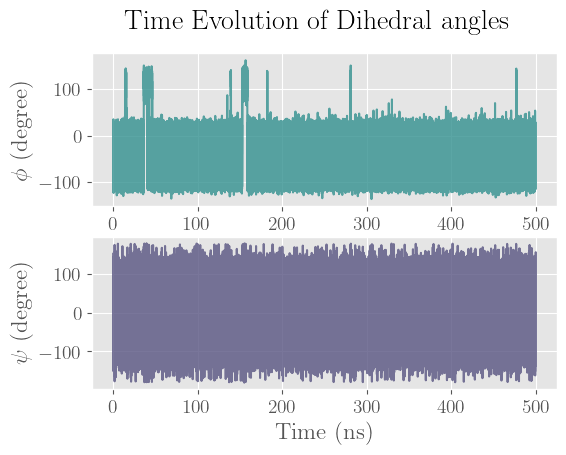

In [4]:
fig, (ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Time Evolution of Dihedral angles')

t = timepoints(phi)

ax1.plot(t,phi,alpha=0.8)
ax1.set_ylabel(r'$\phi$ (degree)');

ax2.plot(t,psi,color='C1',alpha=0.8)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel(r'$\psi$ (degree)');

To visualize the evolution of the dihedral angles, we can 'zoom in' to various sections of these plots, as illustrated in the following graphs:

In [5]:
# to get the indices where the conformation 'jumps' happen,
# from a visual estimate of the time in nanoseconds:
np.where(((t>=140) & (t<=160)))[0]

array([700000, 700001, 700002, ..., 799998, 799999, 800000])

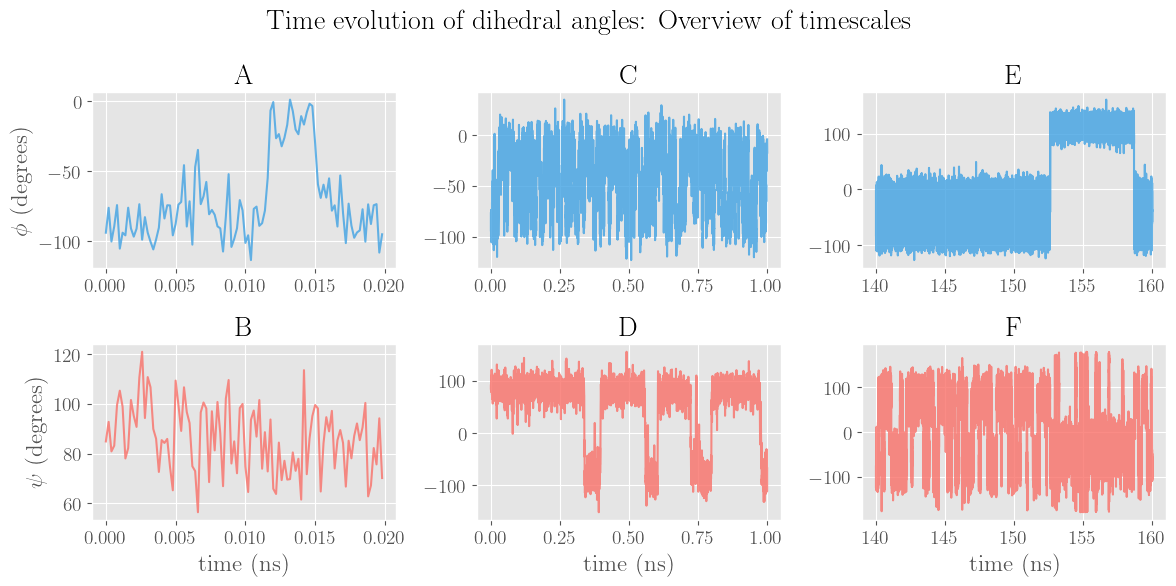

In [6]:
fig, axs = plt.subplots(2, 3,figsize=(11.998293,5.999146))

axs[0,0].plot(t[:100],phi[:100],alpha=0.8,color='C5')
axs[1,0].plot(t[:100],psi[:100],alpha=0.8,color='C3')
axs[1,0].set_xlabel('time (ns)')

axs[0,1].plot(t[:5_000],phi[:5_000],alpha=0.8,color='C5')
axs[1,1].plot(t[:5_000],psi[:5_000],alpha=0.8,color='C3')
axs[1,1].set_xlabel('time (ns)')

axs[0,2].plot(t[700_000:800_000],phi[700_000:800_000],alpha=0.8,color='C5')
axs[1,2].plot(t[700_000:800_000],psi[700_000:800_000],alpha=0.8,color='C3')
axs[1,2].set_xlabel('time (ns)')

axs[0,0].set_ylabel(r'$\phi$ (degrees)')
axs[1,0].set_ylabel(r'$\psi$ (degrees)')

axs[0,0].set_title("A")
axs[1,0].set_title("B")

axs[0,1].set_title("C")
axs[1,1].set_title("D")

axs[0,2].set_title("E")
axs[1,2].set_title("F")

fig.suptitle('Time evolution of dihedral angles: Overview of timescales')
plt.tight_layout()
plt.savefig('./final_plots/dihedral_evolution.pdf')

## Ramachandran plot and free energy

Now, we can visualize the 2D-distribution of these angles in a histogram, called the **Ramachandran Plot**:

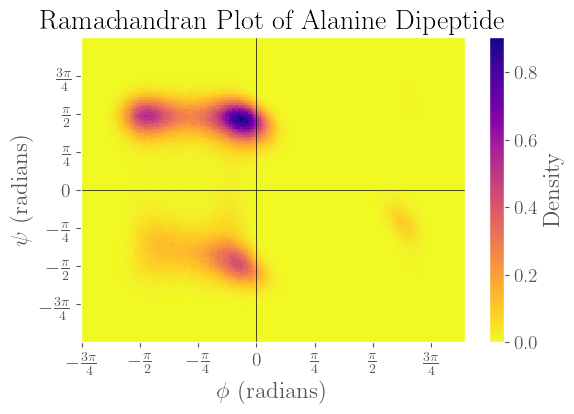

In [7]:
# Setting the bin size for the histogram
bin_size = 200

# Creating the 2D histogram
histogram, xedges, yedges, image = plt.hist2d(phi_rad, psi_rad, bins=bin_size, density=True,cmap='plasma_r') # alternate ocean

# Plot settings
plt.colorbar(label='Density')
plt.xlabel(r'$\phi$ (radians)')
plt.ylabel(r'$\psi$ (radians)')
plt.title('Ramachandran Plot of Alanine Dipeptide')
ax = set_ticks()

ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)


plt.tight_layout()
plt.savefig('./final_plots/Rama_plot_initial.pdf')

# The density in the plot represents the 
# frequency of each angle pair in the trajectory.
# This will help us observe the number of states 
# (point accumulations) and compare the barriers between states.

We can also create the 2d histogram for the free energy, which due to the logarithmic scale, offers better visibility of the different states.

The `calculate_free_energy` computes the free energy of the distribution using the relation:

$$\Delta G(\phi, \psi) = -\ln\left(\frac{P(\phi, \psi) + \rho_{\text{min}}}{\rho_{\text{max}}}\right)$$

The $\rho_{\text{min}}$ is included so as to avoid taking $\ln(0)$, and $\rho_{\text{max}}$ normalizes the distribution.

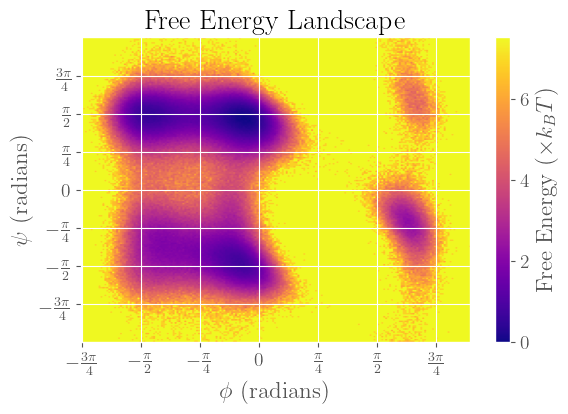

In [8]:

def calculate_free_energy(phi, psi, bin_size):
    """
    Calculate the free energy from phi and psi angles.
    
    Input: dihedral angles in radians, temperature and bin-size
    Returns: histogram and corresponding x- and y-edges of free energy
    """
   
    # Compute the 2D distribution (histogram)
    hist, xedges, yedges = np.histogram2d(phi, psi, bins=bin_size, density=True)
    
    # Compute the free energy ΔG(V1, V2)
    # To avoid taking log of 0, we add a small number inside the log
    rho_min = np.min(hist[hist > 0])  # Minimum non-zero value of the histogram
    rho = hist + rho_min
    rho_max = hist.max()

    delta_G = - np.log(rho / rho_max)
    
    return hist, delta_G, xedges, yedges

bin_size = 200  # bins defined after trial and error

# Calculate histogram and free energy
hist, delta_G, xedges, yedges = calculate_free_energy(phi_rad, psi_rad, bin_size)

# Plot the free energy landscape
plt.figure()
# Define the extent of the histogram for plotting
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(delta_G.T, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')
plt.xlabel(r'$\phi$ (radians)')
plt.ylabel(r'$\psi$ (radians)')
plt.title('Free Energy Landscape')

ax = set_ticks()

plt.tight_layout()
plt.savefig('./final_plots/free_energy_initial.pdf')

In [9]:
def calculate_1d_free_energy(dihedral_angles, bin_size):
    """
    Calculate the 1D free energy from a given array of phi or psi.
    
    Returns:
    - free_energy: 1D array of free energy values.
    - bin_edges: Edges of the histogram bins.
    """
    # Compute the 1D histogram (distribution)
    hist, bin_edges = np.histogram(dihedral_angles, bins=bin_size, density=True)
    
    # Compute the free energy F = -kT * ln(hist)
    # To avoid taking log of 0, we add a small number inside the log
    hist_min = np.min(hist[hist > 0])  # Minimum non-zero value of the histogram
    rho = hist + hist_min
    free_energy = -np.log(rho)
    free_energy -= np.min(free_energy)  # Normalize to set the minimum free energy to zero
    
    return free_energy, bin_edges


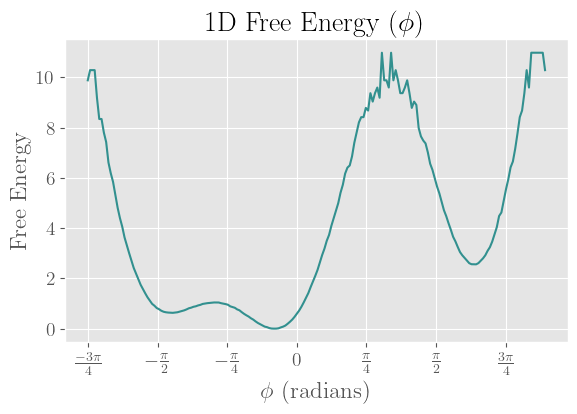

In [10]:
# Calculate the 1D free energy
phi_free_energy, bin_edges = calculate_1d_free_energy(phi_rad, bin_size=200)

# Get the middle points of the bins for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the 1D free energy distribution
plt.plot(bin_centers, phi_free_energy)
plt.xlabel(r'$\phi$ (radians)')
plt.ylabel('Free Energy')
plt.title(r'1D Free Energy ($\phi$)')

ax=set_ticks_1d()
plt.tight_layout()
plt.savefig('final_plots/1d_phi_initial.pdf')


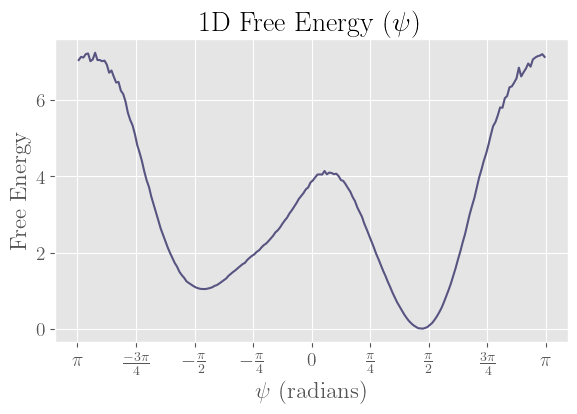

In [11]:
# Calculate the 1D free energy
psi_free_energy, bin_edges = calculate_1d_free_energy(psi_rad, bin_size=200)

# Get the middle points of the bins for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the 1D free energy distribution
plt.plot(bin_centers, psi_free_energy,color='C1')
plt.xlabel(r'$\psi$ (radians)')
plt.ylabel('Free Energy')
plt.title(r'1D Free Energy ($\psi$)')

ax=set_ticks_1d()
plt.tight_layout()
plt.savefig('final_plots/1d_psi_initial.pdf')

The coordinates of interest can also be seen from a simple 1D distribution of the given dihedral angle data:

367 167


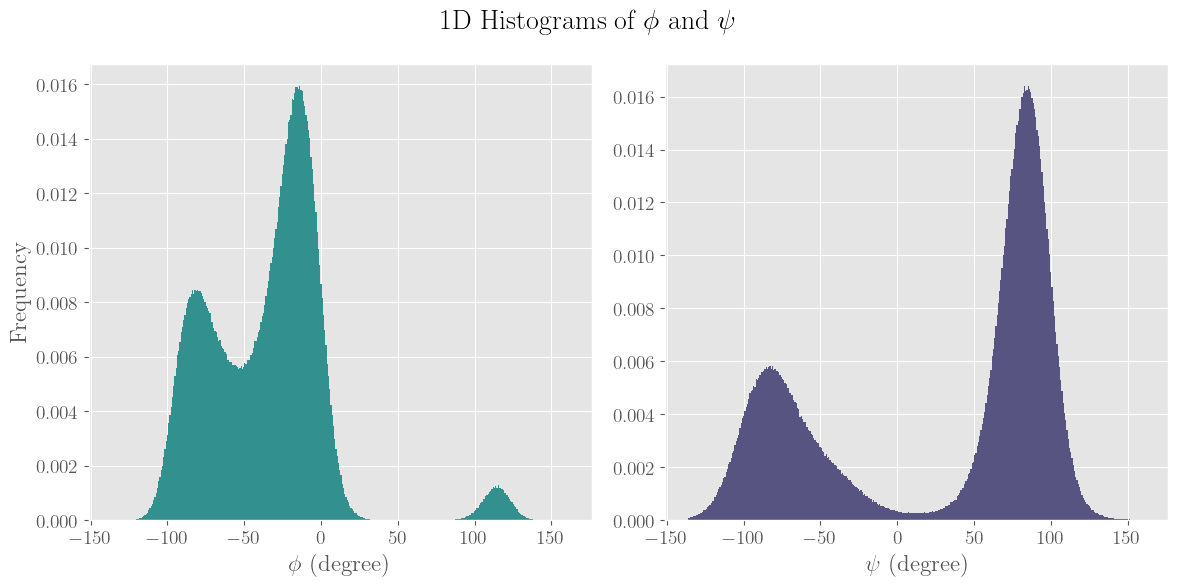

In [12]:
bins_phi = np.histogram_bin_edges(phi, bins='auto')
bins_psi = np.histogram_bin_edges(psi, bins='auto')

fig,axs = plt.subplots(1,2,figsize=(11.998293,5.999146))

fig.suptitle('1D Histograms of $\phi$ and $\psi$')

axs[0].hist(phi,bins=bins_phi,color='C0',density=True);
axs[0].set_xlabel(r'$\phi$ (degree)')
axs[0].set_ylabel('Frequency')

axs[1].hist(psi,bins=bins_phi,color='C1',density=True);
axs[1].set_xlabel(r'$\psi$ (degree)')

print(len(bins_phi),len(bins_psi))

plt.tight_layout()
plt.savefig('./final_plots/1d_phi_psi.pdf')

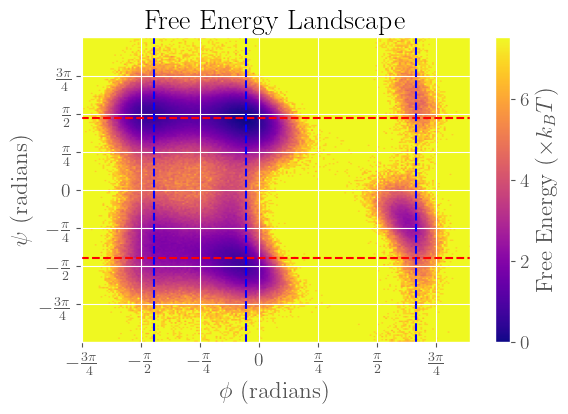

In [13]:
phi1 = -10
phi2 = -80
phi3 = 120

psi1 = -80
psi2 = 85

phi_minima = np.radians(np.array([phi1,phi2,phi3]))
psi_minima = np.radians(np.array([psi1,psi2]))

# Calculate histogram and free energy
hist, delta_G, xedges, yedges = calculate_free_energy(phi_rad, psi_rad, bin_size)

# Plot the free energy landscape
plt.figure()
# Define the extent of the histogram for plotting
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(delta_G.T, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')
plt.xlabel(r'$\phi$ (radians)')
plt.ylabel(r'$\psi$ (radians)')
plt.title('Free Energy Landscape')

ax = set_ticks()

plt.tight_layout()

plt.axhline(psi_minima[0],linestyle='--',color='red')
plt.axhline(psi_minima[1],linestyle='--',color='red')
plt.axvline(phi_minima[0],linestyle='--',color='blue')
plt.axvline(phi_minima[1],linestyle='--',color='blue')
plt.axvline(phi_minima[2],linestyle='--',color='blue')

# plt.hlines(y=[psi1,psi2],xmin=-100,xmax=150,linestyles='--',colors='red',label=r'minima of $\psi$')
# plt.vlines(x=[phi1,phi2,phi3],ymin=-100,ymax=150,linestyles='--',colors='blue',label=r'minima of $\phi$')

plt.savefig('./final_plots/free_energy_initial_annotated.pdf')

So the energy minima seen from the 1d projections correspond to the states observed in the Ramachandran plot.

# Task II

This task involves doing a Principal Component Analysis as performed in the Exercise IX of the course. Following similar steps as outlined in the task guidelines, we perform a PCA to the dihedral angle coordinates:

In [14]:
# Means
phi_mean = phi_rad.mean()
psi_mean = psi_rad.mean()

# Covariance and variance
phi_variance = phi_rad.var()
psi_variance = psi_rad.var()

# Covariance matrix
covariance_matrix = np.cov(phi_rad,psi_rad)
print(f'Covariance matrix:\n {np.around(covariance_matrix,2)}')

eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Reordering eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
print(f'\nEigen values: {[round(i,2) for i in eigenvalues]}')
eigenvectors = eigenvectors[:, idx]
print(f'Sorted eigen vectors: \n{eigenvectors}\n')

# Principal components:
pc1 = eigenvectors[:, 0]  # First principal component
pc2 = eigenvectors[:, 1]  # Second principal component

print(f'Principal components:\n{pc1,pc2}')

Covariance matrix:
 [[ 0.49 -0.15]
 [-0.15  1.8 ]]

Eigen values: [1.81, 0.47]
Sorted eigen vectors: 
[[ 0.11003329 -0.9939279 ]
 [-0.9939279  -0.11003329]]

Principal components:
(array([ 0.11003329, -0.9939279 ]), array([-0.9939279 , -0.11003329]))


In [15]:
# Subtracting the mean from the data
phi_centered = phi_rad - phi_mean
psi_centered = psi_rad - psi_mean

# Stacking the centered data for matrix multiplication
centered_data = np.stack((phi_centered, psi_centered), axis=1)

# Projecting the data onto the principal components
projected_data = np.dot(centered_data, eigenvectors)

V1,V2 = projected_data[:, 0], projected_data[:, 1]

In [16]:
def scree_data(eigenvalues):
    percent_variance_explained = 100 * eigenvalues / eigenvalues.sum()

    return percent_variance_explained

Principal Component 1: 79.29% of the total variance
Principal Component 2: 20.71% of the total variance


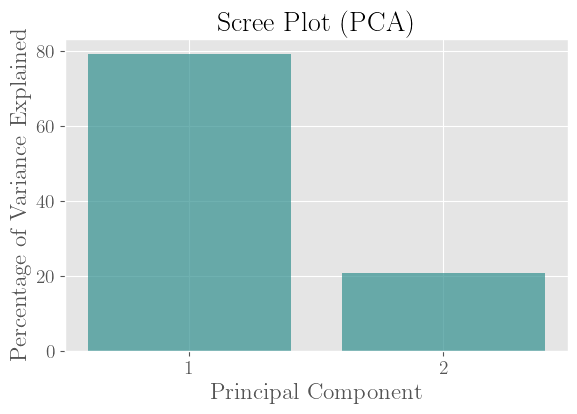

In [17]:
# Calculate the percentage of variance explained by each principal component
percent_variance_explained = scree_data(eigenvalues)

# Visualize the PCA results using a scree plot with percentages
plt.bar(range(1, len(eigenvalues) + 1), percent_variance_explained, alpha=0.7)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Scree Plot (PCA)')
plt.xticks(range(1, len(eigenvalues) + 1))

# Print the percentage of the total variance that each principal component accounts for
for i, variance in enumerate(percent_variance_explained):
    print(f'Principal Component {i+1}: {variance:.2f}% of the total variance')

plt.tight_layout()
plt.savefig('./final_plots/scree_PCA.pdf')

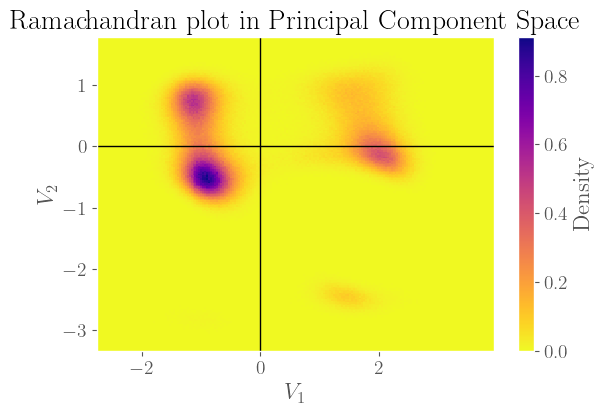

In [18]:
plt.figure()
plt.hist2d(V1,V2, bins=200, density=True,cmap='plasma_r')
plt.colorbar(label='Density')
plt.xlabel(r'$V_1$')
plt.ylabel(r'$V_2$')
plt.title('Ramachandran plot in Principal Component Space')
plt.grid(True)
plt.tight_layout()

ax = plt.gca()
ax.axvline(0,color='black',lw=1)
ax.axhline(0,color='black',lw=1)

plt.tight_layout()
plt.savefig('./final_plots/Rama_PCA.pdf')

plt.show()

Again, we can take a look at the free energy for better visibility:

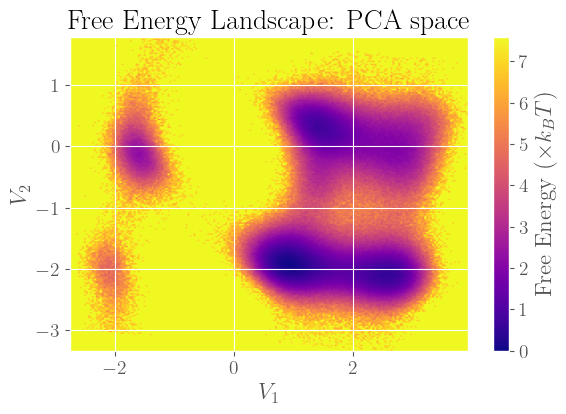

In [19]:
# Calculate histogram and free energy
hist_pca, delta_G_pca, xedges_pca, yedges_pca = calculate_free_energy(V1, V2, bin_size)

# Plot the free energy landscape
plt.figure()
# Define the extent of the histogram for plotting
extent = [xedges_pca[0], xedges_pca[-1], yedges_pca[0], yedges_pca[-1]]
plt.imshow(delta_G_pca, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')
plt.xlabel(r'$V_1$')
plt.ylabel(r'$V_2$')
plt.title('Free Energy Landscape: PCA space')

# ax = set_ticks()

plt.tight_layout()
plt.savefig('./final_plots/free_energy_PCA.pdf')

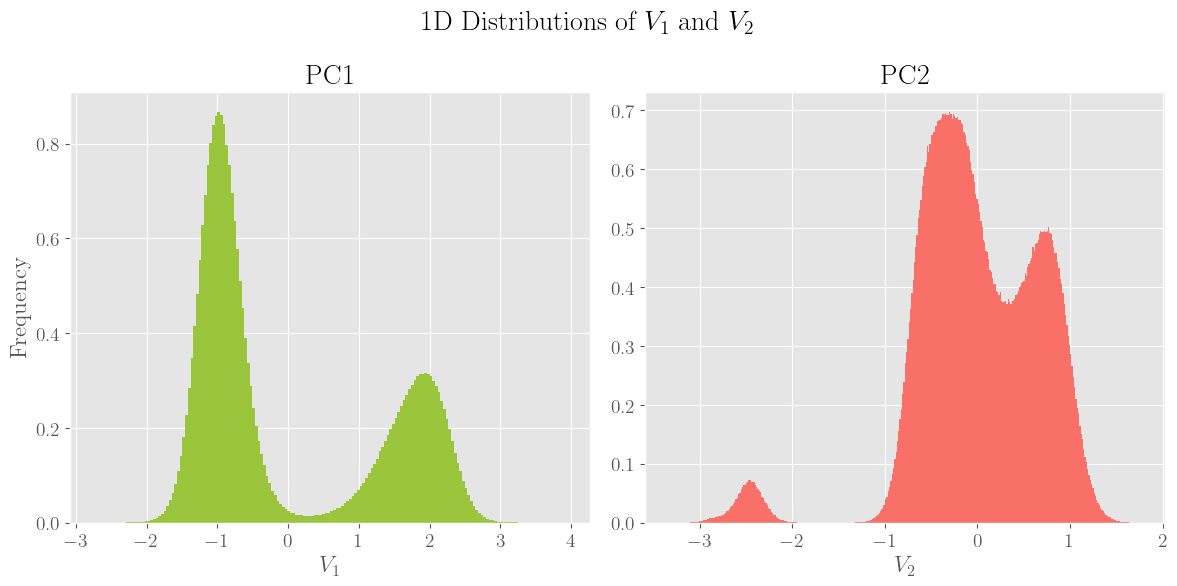

In [20]:
bins_V1 = np.histogram_bin_edges(V1, bins='auto')
bins_V2 = np.histogram_bin_edges(V2, bins='auto')

fig,axs = plt.subplots(1,2,figsize=(11.998293,5.999146))

fig.suptitle('1D Distributions of $V_1$ and $V_2$')

axs[0].hist(V1,bins=bins_V1,color='C2',density=True);
axs[0].set_xlabel(r'$V_1$')
axs[0].set_ylabel('Frequency')
axs[0].set_title('PC1')

axs[1].hist(V2,bins=bins_V2,color='C3',density=True);
axs[1].set_xlabel(r'$V_2$')
axs[1].set_title('PC2')

plt.tight_layout()
plt.savefig('./final_plots/1d_v1_v2.pdf')

# Task III

In [21]:
# Project the angles onto sine and cosine space
sin_phi = np.sin(phi_rad)
cos_phi = np.cos(phi_rad)
sin_psi = np.sin(psi_rad)
cos_psi = np.cos(psi_rad)

In [22]:
# Means
sin_phi_mean = sin_phi.mean()
cos_phi_mean = cos_phi.mean()
sin_psi_mean = sin_psi.mean()
cos_psi_mean = cos_psi.mean()

# Covariance matrix
stacked_arr = np.vstack([sin_phi,cos_phi,sin_psi,cos_psi])
print(stacked_arr.shape)
covariance_matrix = np.cov(stacked_arr)
print(f'Covariance matrix:\n {covariance_matrix}')
print(f'Dimension: {covariance_matrix.shape}')

eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Reordering eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
print(f'\nEigen values: {[round(i,2) for i in eigenvalues]}')
eigenvectors = eigenvectors[:, idx]
print(f'Sorted eigen vectors: \n{eigenvectors}\n')

# Principal components:
pc1 = eigenvectors[:, 0]  # First principal component
pc2 = eigenvectors[:, 1]  # Second principal component
pc3 = eigenvectors[:, 2]  # Third principal component
pc4 = eigenvectors[:, 3]  # Fourth principal component

print(f'Principal components:\n{pc1}\n{pc2}\n{pc3}\n{pc4}')

(4, 2500000)
Covariance matrix:
 [[ 0.18429202  0.07555427 -0.0390987   0.01756248]
 [ 0.07555427  0.16486931 -0.00904187 -0.01042206]
 [-0.0390987  -0.00904187  0.7597456  -0.04233677]
 [ 0.01756248 -0.01042206 -0.04233677  0.1098412 ]]
Dimension: (4, 4)

Eigen values: [0.77, 0.25, 0.12, 0.08]
Sorted eigen vectors: 
[[ 0.071886    0.74479202  0.39101899 -0.53593041]
 [ 0.02287625  0.66315674 -0.47374502  0.57902113]
 [-0.99497704  0.07057578  0.06934195  0.01521352]
 [ 0.06580106  0.02295746  0.78604166  0.6142326 ]]

Principal components:
[ 0.071886    0.02287625 -0.99497704  0.06580106]
[0.74479202 0.66315674 0.07057578 0.02295746]
[ 0.39101899 -0.47374502  0.06934195  0.78604166]
[-0.53593041  0.57902113  0.01521352  0.6142326 ]


Principal Component 1: 73.62% of the total variance
Principal Component 2: 26.38% of the total variance


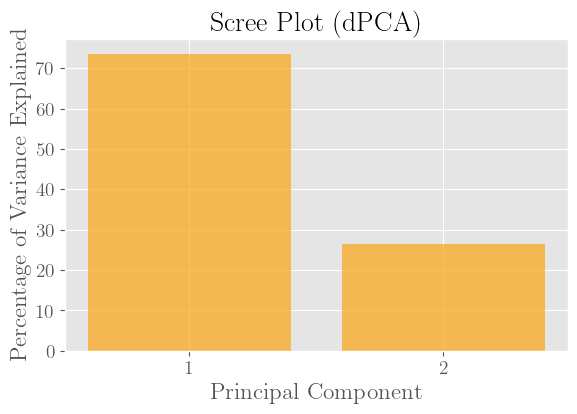

In [44]:
# Calculate the percentage of variance explained by each principal component
percent_variance_explained = scree_data(eigenvalues)

# Visualize the PCA results using a scree plot with percentages
plt.bar(range(1, len(eigenvalues) + 1), percent_variance_explained, color='C4' ,alpha=0.7)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Scree Plot (dPCA)')
plt.xticks(range(1, len(eigenvalues) + 1))
# plt.show()

# Print the percentage of the total variance that each principal component accounts for
for i, variance in enumerate(percent_variance_explained):
    print(f'Principal Component {i+1}: {variance:.2f}% of the total variance')

plt.tight_layout()
plt.savefig('./final_plots/scree_dPCA.pdf')

Here we clearly see how the method of PCA reduces the dimensionality. Although we mapped our $2N$ set of data to a $4N$ space, the method of PCA helps reduce the extra dimensionality introduced. 

From the above plot, we see that about $63\%$ of the total variance can be explained by PC1 alone. If PC2 is included, $83\%$ of the variance can be explained, and so on.

In [24]:
# Subtracting the mean from the data
sin_phi_centered = sin_phi #- sin_phi_mean
cos_phi_centered = cos_phi #- cos_phi_mean
sin_psi_centered = sin_psi #- sin_psi_mean
cos_psi_centered = cos_psi #- cos_psi_mean

# Stacking the centered data for matrix multiplication
centered_data = np.stack((sin_phi_centered,cos_phi_centered,sin_psi_centered,cos_psi_centered), axis=1)

# Projecting the data onto the principal components
projected_data = np.dot(centered_data, eigenvectors)

V1,V2,V3,V4 = projected_data[:, 0], projected_data[:, 1], projected_data[:, 2],projected_data[:, 3]

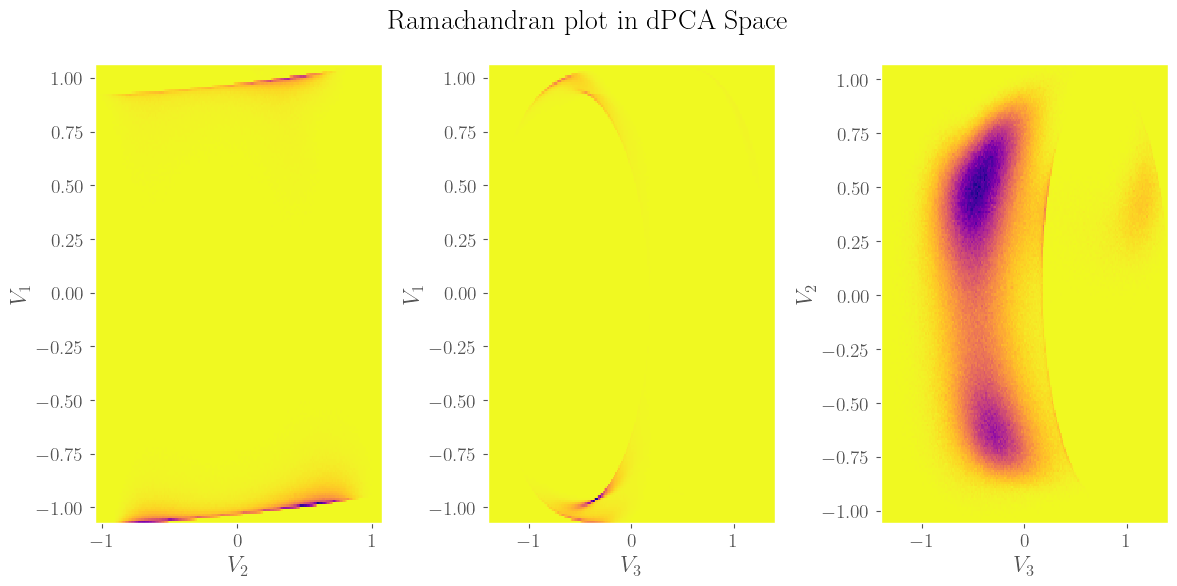

In [25]:
fig,axs = plt.subplots(1,3,figsize=(11.998293,5.999146))

fig.suptitle('Ramachandran plot in dPCA Space')

axs[0].hist2d(V2,V1, bins=200, density=True,cmap='plasma_r')
axs[0].set_xlabel(r'$V_2$')
axs[0].set_ylabel(r'$V_1$')
# axs[0].set_aspect('equal')

axs[1].hist2d(V3,V1, bins=200, density=True,cmap='plasma_r')
axs[1].set_xlabel(r'$V_3$')
axs[1].set_ylabel(r'$V_1$')
# axs[1].set_aspect('equal')

axs[2].hist2d(V3,V2, bins=200, density=True,cmap='plasma_r')
axs[2].set_xlabel(r'$V_3$')
axs[2].set_ylabel(r'$V_2$')
# axs[2].set_aspect('equal')

# ax = plt.gca()
# ax.axvline(0,color='black',lw=1)
# ax.axhline(0,color='black',lw=1)

plt.tight_layout()
plt.savefig('./final_plots/Rama_dPCA_V1_V2.pdf')

plt.show()

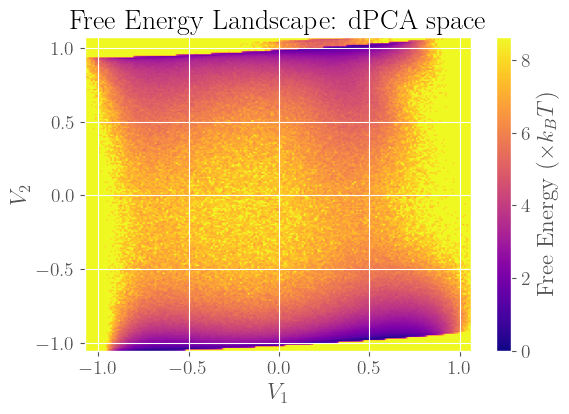

In [26]:
# Calculate histogram and free energy
hist1_dpca, delta_G1_dpca, xedges1_dpca, yedges1_dpca = calculate_free_energy(V1, V2, bin_size)
hist2_dpca, delta_G2_dpca, xedges2_dpca, yedges2_dpca = calculate_free_energy(V1, V3, bin_size)
hist3_dpca, delta_G3_dpca, xedges3_dpca, yedges3_dpca = calculate_free_energy(V3, V2, bin_size)

# Plot the free energy landscape
plt.figure()
# Define the extent of the histogram for plotting
extent = [xedges1_dpca[0], xedges1_dpca[-1], yedges1_dpca[0], yedges1_dpca[-1]]
plt.imshow(delta_G1_dpca, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')
plt.xlabel(r'$V_1$')
plt.ylabel(r'$V_2$')
plt.title('Free Energy Landscape: dPCA space')

# ax = set_ticks()

plt.tight_layout()
plt.savefig('./final_plots/free_energy_dPCA_V1_V2.pdf')

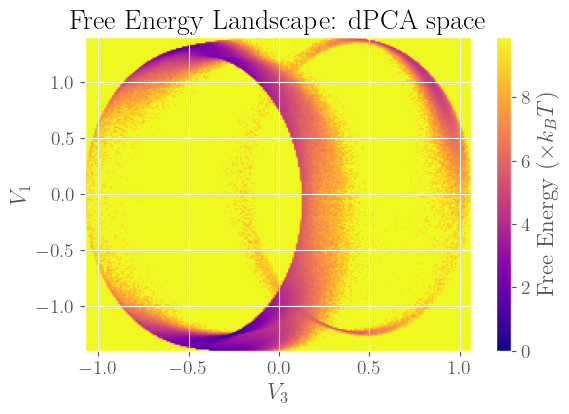

In [27]:
extent = [xedges2_dpca[0], xedges2_dpca[-1], yedges2_dpca[0], yedges2_dpca[-1]]
plt.imshow(delta_G2_dpca, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')
plt.xlabel(r'$V_3$')
plt.ylabel(r'$V_1$')
plt.title('Free Energy Landscape: dPCA space')

# ax = set_ticks()

plt.tight_layout()
plt.savefig('./final_plots/free_energy_dPCA_V1_V3.pdf')

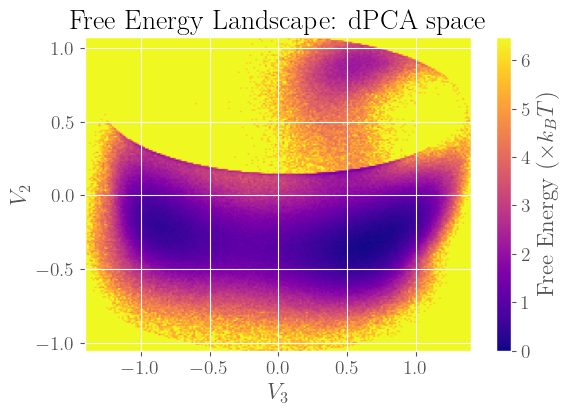

In [28]:
extent = [xedges3_dpca[0], xedges3_dpca[-1], yedges3_dpca[0], yedges3_dpca[-1]]
plt.imshow(delta_G3_dpca, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')
plt.xlabel(r'$V_3$')
plt.ylabel(r'$V_2$')
plt.title('Free Energy Landscape: dPCA space')

# ax = set_ticks()

plt.tight_layout()
plt.savefig('./final_plots/free_energy_dPCA_V2_V3.pdf')

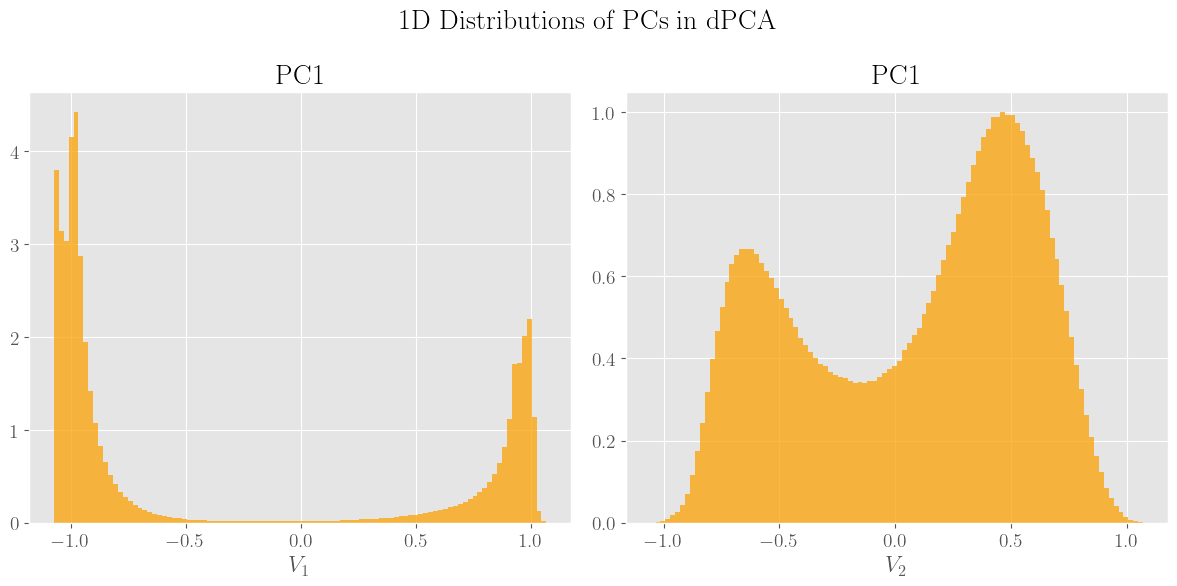

In [29]:
bins_V1 = np.histogram_bin_edges(V1, bins=100)
bins_V2 = np.histogram_bin_edges(V2, bins=100)

fig,axs = plt.subplots(1,2,figsize=(11.998293,5.999146))

fig.suptitle('1D Distributions of PCs in dPCA')

axs[0].hist(V1,bins=bins_V1,color='C4',density=True,alpha=0.8)
axs[1].hist(V2,bins=bins_V2,color='C4',density=True,alpha=0.8)

axs[0].set_xlabel(r'$V_1$')
axs[0].set_title(r'PC1')
axs[1].set_title(r'PC1')
axs[1].set_xlabel(r'$V_2$')

plt.tight_layout()
plt.savefig('./final_plots/1d_dPCA_V1_V2.pdf')

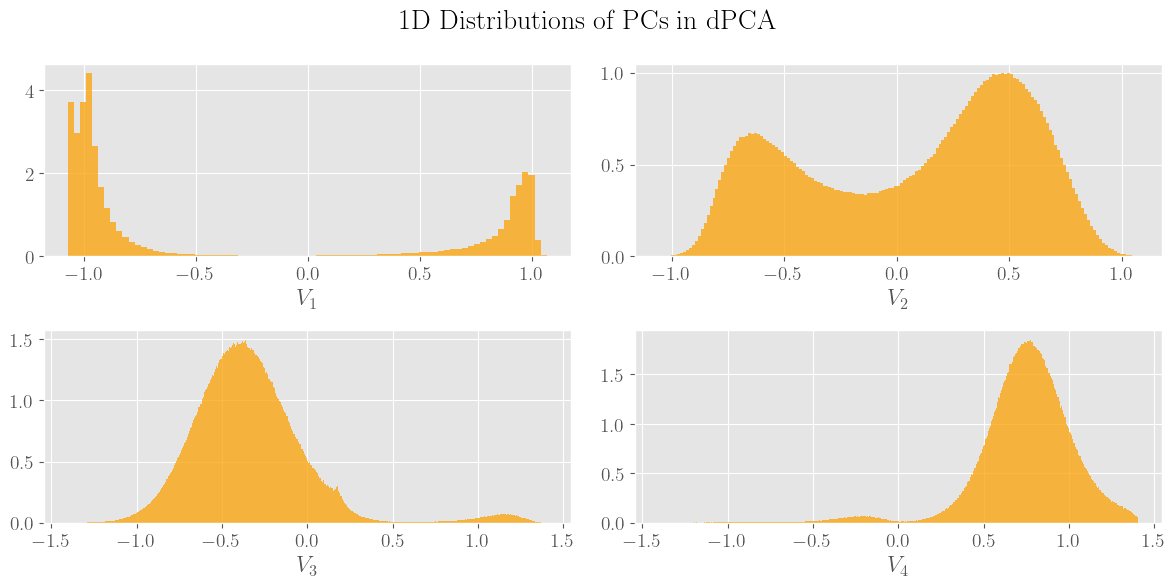

In [30]:
bins_V1 = np.histogram_bin_edges(V1, bins='auto')
bins_V2 = np.histogram_bin_edges(V2, bins='auto')
bins_V3 = np.histogram_bin_edges(V3, bins='auto')
bins_V4 = np.histogram_bin_edges(V4, bins='auto')

fig,axs = plt.subplots(2,2,figsize=(11.998293,5.999146))

fig.suptitle('1D Distributions of PCs in dPCA')

axs[0,0].hist(V1,bins=bins_V1,color='C4',density=True,alpha=0.8)
axs[0,1].hist(V2,bins=bins_V2,color='C4',density=True,alpha=0.8)
axs[1,0].hist(V3,bins=bins_V3,color='C4',density=True,alpha=0.8)
axs[1,1].hist(V4,bins=bins_V4,color='C4',density=True,alpha=0.8)

axs[0,0].set_xlabel(r'$V_1$')
axs[0,1].set_xlabel(r'$V_2$')
axs[1,0].set_xlabel(r'$V_3$')
axs[1,1].set_xlabel(r'$V_4$')

plt.tight_layout()
plt.savefig('./final_plots/1d_dPCA_all_four.pdf')

# Task IV

An initial visual guess of the offset angle is made, by looking at the density of points in different regions of the 2D heatmap of the free energy. The guessed 'cut' values are annotated in the plot below:

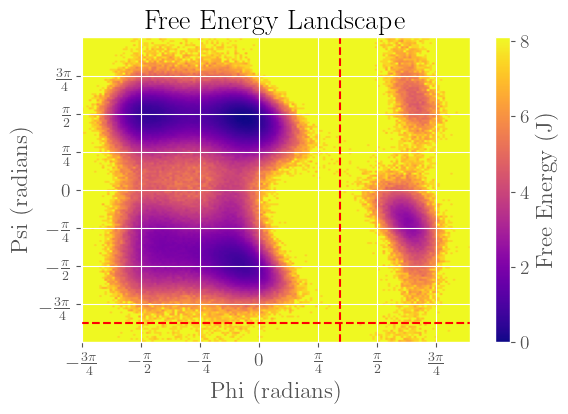

In [31]:
bin_size = 150

# Calculate histogram and free energy
hist, delta_G, xedges, yedges = calculate_free_energy(phi_rad, psi_rad, bin_size)

# Plot the free energy landscape
plt.figure()
# Define the extent of the histogram for plotting
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(delta_G.T, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label='Free Energy (J)')
plt.xlabel('Phi (radians)')
plt.ylabel('Psi (radians)')
plt.title('Free Energy Landscape')

plt.axvline((11/32)*np.pi,color='red',linestyle='--')
plt.axhline(-(7/8)*np.pi,color='red',linestyle='--')

ax = set_ticks()

plt.tight_layout()
plt.savefig('./final_plots/free_energy_max_gap.pdf')

The guessed cut points can also be visualized in the 1D distributions:

367 167


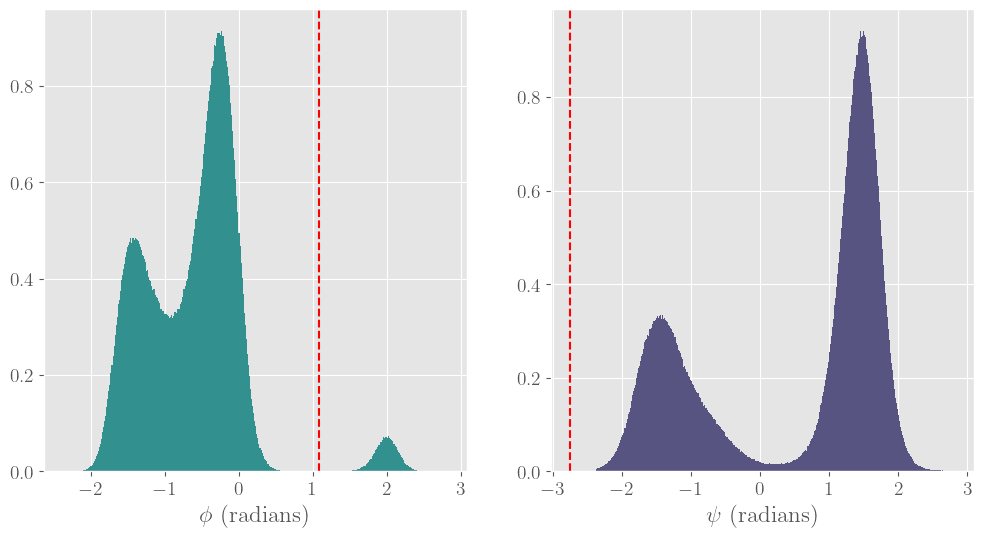

In [32]:
guess_cut1=(11/32)*np.pi # naming the cuts
guess_cut2=-(7/8)*np.pi

# Re-generate the density histograms for phi and psi

bins_phi = np.histogram_bin_edges(phi_rad, bins='auto')
bins_psi = np.histogram_bin_edges(psi_rad, bins='auto')

print(len(bins_phi),len(bins_psi))

fig,axs = plt.subplots(1,2,figsize=(11.998293,5.999146))

axs[0].hist(phi_rad,bins=bins_phi,color='C0',density=True);
axs[0].axvline(guess_cut1,color='red',linestyle='--')
axs[0].set_xlabel(r'$\phi$ (radians)')

axs[1].hist(psi_rad,bins=bins_phi,color='C1',density=True);
axs[1].axvline(guess_cut2,color='red',linestyle='--')
axs[1].set_xlabel(r'$\psi$ (radians)')

plt.savefig('./final_plots/1d_maximal_gaps.pdf')


Now, the guessed cut value is optimized by defining the following search function `find_best_maximal_gap` which takes in the histogram data and identifies the best bin to shift the data. The numpy function `searchsorted` is utilized for this purpose. This function takes a sorted array (`bin_edges` in this case) and a value (`guess_value`) and returns the index at which this value should be inserted to maintain the order of the array.

In [33]:
def find_best_maximal_gap(hist, guess_value):
    """
    Find the best value of the variable for the maximal gap based 
    on the guessed value.
    """
    counts, bin_edges = hist
    bin_width = bin_edges[1] - bin_edges[0]

    # Find the index of the bin which contains the guess value
    guess_index = np.searchsorted(bin_edges, guess_value, side='right') - 1

    ## Look for the bin with the minimal count near the guess value
    search_range = 20
    start = max(0, guess_index - search_range)
    end = min(len(counts), guess_index + search_range)
    
    # Locate the index of the bin with the lowest count 
    #  within the specified range.
    min_count_index = np.argmin(counts[start:end]) + start

    # Calculate the midpoint of the bin with the minimal count
    best_value = bin_edges[min_count_index] + bin_width / 2

    print(f'Guessed cut:{guess_value:.3f},\n Optimized cut:{best_value:.3f}')
    
    return best_value

The side='right' argument in the above function specifies that the insertion index should be such that the `guess_value` is inserted just after any existing entries of the same value in `bin_edges`. In other words, it finds the index where guess_value should go if all values in bin_edges are considered to be the left edges of the intervals. For example, if `guess_value` is 3.5 and `bin_edges` has a bin edge exactly at 3, then searchsorted with `side='right'` would return the index after 3.

In [34]:
cut1=find_best_maximal_gap(np.histogram(phi_rad,bins='auto'),guess_cut1)
cut2=find_best_maximal_gap(np.histogram(psi_rad,bins='auto'),guess_cut2)

Guessed cut:1.080,
 Optimized cut:0.922
Guessed cut:-2.749,
 Optimized cut:-3.007


Visualizing the optimized cuts in comparison to the original cuts:

In [35]:
np.rad2deg(cut1),np.rad2deg(cut2)

(52.81541803278686, -172.31668373493977)

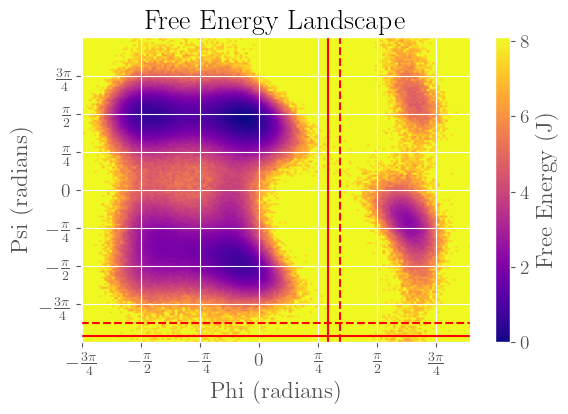

In [36]:
bin_size = 150

# Calculate histogram and free energy
hist, delta_G, xedges, yedges = calculate_free_energy(phi_rad, psi_rad, bin_size)

# Plot the free energy landscape
plt.figure()
# Define the extent of the histogram for plotting
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(delta_G.T, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label='Free Energy (J)')
plt.xlabel('Phi (radians)')
plt.ylabel('Psi (radians)')
plt.title('Free Energy Landscape')

plt.axvline(guess_cut1,color='red',linestyle='--')
plt.axvline(cut1,color='red',linestyle='-')
plt.axhline(guess_cut2,color='red',linestyle='--')
plt.axhline(cut2,color='red',linestyle='-')

ax = set_ticks()

plt.tight_layout()
plt.savefig('./final_plots/free_energy_max_gap_best.pdf')

Now we write a function to shift the offset angles by the periodic boundary.

In [37]:
def shift_angles(angles,cut):
    transformed_angles = np.zeros_like(angles)

    # Shift the angles based on the cut point
    shifted_angles = (angles - cut) % (2 * np.pi) - np.pi
    # The periodic boundary is ensured by using the modulo operatiom,
    # mapping the angles to a range 0 to pi first, and then 
    # subtracting by pi to map them back to the [-pi,pi) range.

    return shifted_angles

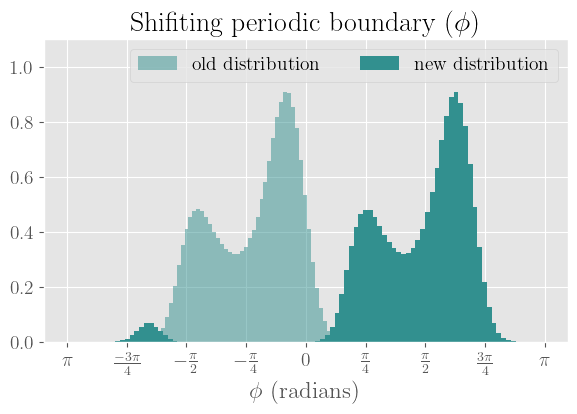

In [38]:
plt.hist(phi_rad,bins=100,color='C0',alpha=0.5,density=True,label='old distribution');

# updating the phi
new_phi = shift_angles(phi_rad,cut1)

plt.hist(new_phi,bins=100,color='C0',alpha=1,density=True,label='new distribution');
plt.ylim(0,1.1)
plt.legend(ncols=2)
plt.title(r'Shifiting periodic boundary ($\phi$)')
plt.xlabel(r'$\phi$ (radians)')
ax = set_ticks_1d()

plt.tight_layout()
plt.savefig('./final_plots/shifting_PB_phi.pdf')

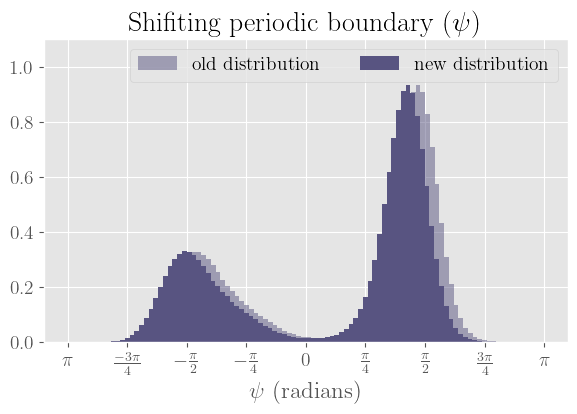

In [39]:
plt.hist(psi_rad,bins=100,color='C1',alpha=0.5,density=True,label='old distribution');

# updating the psi
new_psi = shift_angles(psi_rad,cut2)

plt.hist(new_psi,bins=100,color='C1',alpha=1,density=True,label='new distribution');
plt.ylim(0,1.1)
plt.legend(ncols=2)
plt.title(r'Shifiting periodic boundary ($\psi$)')
plt.xlabel(r'$\psi$ (radians)')
ax = set_ticks_1d()

plt.tight_layout()
plt.savefig('./final_plots/shifting_PB_psi.pdf')

In [40]:
# Means
phi_mean = new_phi.mean()
psi_mean = new_psi.mean()

# Covariance and variance
phi_variance = new_phi.var()
psi_variance = new_psi.var()

# Covariance matrix
covariance_matrix = np.cov(new_phi,new_psi)

eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Reordering eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
print(f'Eigen values: {[round(i,2) for i in eigenvalues]}')
eigenvectors = eigenvectors[:, idx]

# Principal components:
pc1 = eigenvectors[:, 0]  # First principal component
pc2 = eigenvectors[:, 1]  # Second principal component

# Subtracting the mean from the data
phi_centered = new_phi - phi_mean
psi_centered = new_psi - psi_mean

# Stacking the centered data for matrix multiplication
centered_data = np.stack((phi_centered, psi_centered), axis=1)

# Projecting the data onto the principal components
projected_data = np.dot(centered_data, eigenvectors)

Eigen values: [1.8, 0.64]


Principal Component 1: 73.62% of the total variance
Principal Component 2: 26.38% of the total variance


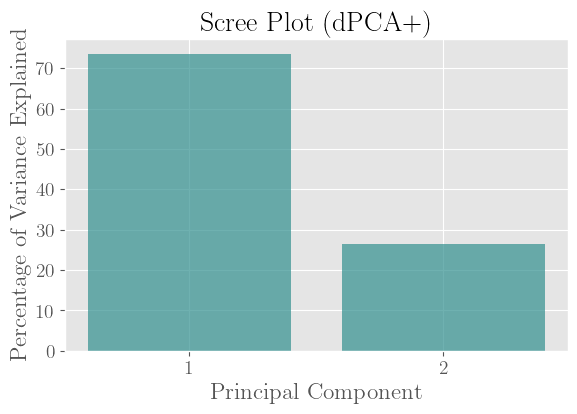

In [41]:
dpcaPlus_scree = scree_data(eigenvalues=eigenvalues)

# Visualize the PCA results using a scree plot with percentages
plt.bar(range(1, len(eigenvalues) + 1), dpcaPlus_scree, alpha=0.7)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Scree Plot (dPCA+)')
plt.xticks(range(1, len(eigenvalues) + 1))

# Print the percentage of the total variance that each principal component accounts for
for i, variance in enumerate(dpcaPlus_scree):
    print(f'Principal Component {i+1}: {variance:.2f}% of the total variance')

plt.tight_layout()
plt.savefig('./final_plots/scree_dPCAplus.pdf')

Text(0.5, 1.0, 'Free Energy Landscape (original)')

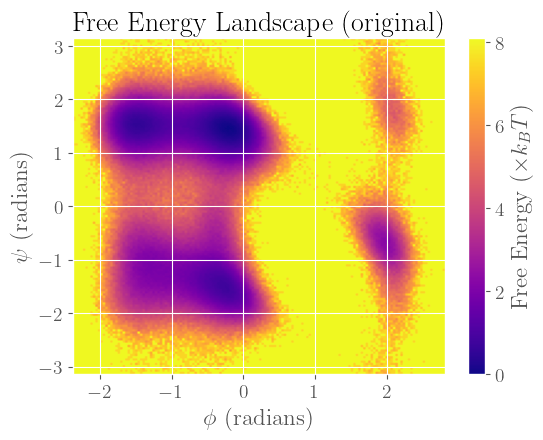

In [42]:
# Calculate histogram and free energy
hist, delta_G, xedges, yedges = calculate_free_energy(phi_rad, psi_rad, bin_size)

# Plot the free energy landscape
plt.figure()
# Define the extent of the histogram for plotting
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(delta_G.T, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')
plt.xlabel(r'$\phi$ (radians)')
plt.ylabel(r'$\psi$ (radians)')
plt.title('Free Energy Landscape (original)')


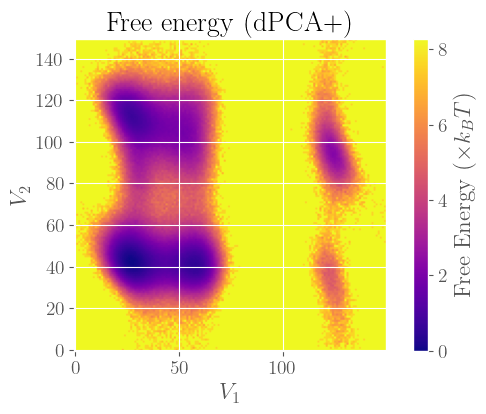

In [43]:
hist_dpcaPlus, delta_G_dpcaPlus, xedges_dpcaPlus, yedges_dpcaPlus = calculate_free_energy(projected_data[:,0],projected_data[:,1], bin_size)
extent = [xedges_dpcaPlus[0], xedges_dpcaPlus[-1], yedges_dpcaPlus[0], yedges_dpcaPlus[-1]]

plt.figure()
plt.grid('False')
plt.imshow(delta_G_dpcaPlus,origin='lower',cmap='plasma')
plt.colorbar(label=r'Free Energy ($\times k_B T$)')

plt.title('Free energy (dPCA+)')
plt.xlabel(r'$V_1$')
plt.ylabel(r'$V_2$')

plt.tight_layout()
plt.savefig('./final_plots/free_energy_dPCAPlus.pdf')

# Appendix

Contents of the `ccs_project_helpers.py` python file:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def angle_difference(a1, a2):
    """
    To calculate the smallest difference between two angles
    """
    # Convert angles to radians
    a1_rad = np.radians(a1)
    a2_rad = np.radians(a2)
    
    # Calculate difference
    diff = np.arctan2(np.sin(a1_rad-a2_rad), np.cos(a1_rad-a2_rad))
    
    # Convert the smallest difference back to degrees
    diff_deg = np.degrees(diff)
    
    # Ensure the difference is within 0-180 degrees
    return np.abs(diff_deg)

# Example angles
a1 = 150
a2 = -150

angle_difference(a1,a2)

def set_ticks(): # majorly generated by ChatGPT
    ax = plt.gca()  # Get current axes
    xmin, xmax = ax.get_xlim()  # Get the limits of the x-axis

    # Convert the limits to multiples of pi/4
    xmin_pi = np.ceil(xmin / (np.pi/4)) * (np.pi/4)
    xmax_pi = np.floor(xmax / (np.pi/4)) * (np.pi/4)

    # Set ticks at multiples of pi/4 within the limits
    ticks_x = np.arange(xmin_pi, xmax_pi + np.pi/4, np.pi/4)

    # Set labels corresponding to the ticks_x
    labels = []
    for tick in ticks_x:
        numerator = int(4*tick/np.pi)
        denominator = 4

        # Simplify the fraction using modulo operation
        while numerator % 2 == 0 and denominator % 2 == 0:
            numerator /= 2
            denominator /= 2

        if numerator == 0:
            labels.append('0')
        elif denominator == 1:
            labels.append(r'$\pi$')
        elif numerator == 1:
            labels.append(fr'$\frac{{\pi}}{{ {int(denominator)} }}$')
        elif numerator == -1:
            labels.append(fr'$-\frac{{\pi}}{{ {int(denominator)} }}$')
        else:
            labels.append(fr'$\frac{{ {int(numerator)} \pi}}{{ {int(denominator)} }}$')

    ymin, ymax = ax.get_ylim()  # Get the limits of the x-axis

    # Convert the limits to multiples of pi/4
    ymin_pi = np.ceil(ymin / (np.pi/4)) * (np.pi/4)
    ymax_pi = np.floor(ymax / (np.pi/4)) * (np.pi/4)

    # Set ticks at multiples of pi/4 within the limits
    ticks_y = np.arange(ymin_pi, ymax_pi + np.pi/4, np.pi/4)

    # Set labels corresponding to the ticks_y
    labels = []
    for tick in ticks_y:
        numerator = int(4*tick/np.pi)
        denominator = 4

        # Simplify the fraction using modulo operation
        while numerator % 2 == 0 and denominator % 2 == 0:
            numerator /= 2
            denominator /= 2
        
        sign = "-" if numerator < 0 else ""
        numerator = abs(numerator)

        if numerator == 0:
            labels.append('0')
        elif denominator == 1:
            labels.append(fr'${sign}\pi$')
        elif numerator == 1:
            labels.append(fr'${sign}\frac{{\pi}}{{ {int(denominator)} }}$')
        else:
            labels.append(fr'${sign}\frac{{ {int(numerator)} \pi}}{{ {int(denominator)} }}$')
    
    ax.set_xticks(ticks_x)
    ax.set_yticks(ticks_y)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    # plt.show()

    return ax

def set_ticks_1d():
    ax = plt.gca()  # Get current axes
    xmin, xmax = ax.get_xlim()  # Get the limits of the x-axis

    # Convert the limits to multiples of pi/4
    xmin_pi = np.ceil(xmin / (np.pi/4)) * (np.pi/4)
    xmax_pi = np.floor(xmax / (np.pi/4)) * (np.pi/4)

    # Set ticks at multiples of pi/4 within the limits
    ticks_x = np.arange(xmin_pi, xmax_pi + np.pi/4, np.pi/4)

    # Set labels corresponding to the ticks_x
    labels = []
    for tick in ticks_x:
        numerator = int(4*tick/np.pi)
        denominator = 4

        # Simplify the fraction using modulo operation
        while numerator % 2 == 0 and denominator % 2 == 0:
            numerator /= 2
            denominator /= 2

        if numerator == 0:
            labels.append('0')
        elif denominator == 1:
            labels.append(r'$\pi$')
        elif numerator == 1:
            labels.append(fr'$\frac{{\pi}}{{ {int(denominator)} }}$')
        elif numerator == -1:
            labels.append(fr'$-\frac{{\pi}}{{ {int(denominator)} }}$')
        else:
            labels.append(fr'$\frac{{ {int(numerator)} \pi}}{{ {int(denominator)} }}$')

    ax.set_xticks(ticks_x)
    ax.set_xticklabels(labels)
    # plt.show()

    return ax

The following function was used to test the PCA implementation using the built-in scikitlearn library.

In [ ]:
def perform_pca(sin_phi, cos_phi, sin_psi, cos_psi):
    """
    Perform PCA on the sine and cosine transformations of the dihedral angles phi and psi.
    """
    
    # Stack the input arrays into a single matrix for PCA
    data = np.column_stack((sin_phi, cos_phi, sin_psi, cos_psi))
    
    # Initialize the PCA model with 4 components
    pca = PCA(n_components=4)
    
    # Fit the PCA model and transform the data
    projected_data = pca.fit_transform(data)
    
    v1,v2,v3,v4 = projected_data.T

    # Return the projected data
    return v1,v2,v3,v4

In [ ]:
from sklearn.decomposition import PCA

V1,V2,V3,V4 = perform_pca(sin_phi,cos_phi,sin_psi,cos_psi)

Contents of the `ccs_project.mplstyle` template file:

```
text.usetex: True
text.latex.preamble: \usepackage{amsmath}\usepackage{amssymb}\usepackage{nicefrac}\usepackage{siunitx}[=v2]

figure.figsize : 5.9991,4.3630 # or (11.998293,5.999146)
figure.titlesize: x-large

font.size: 14.0
font.family: serif
font.serif: cmbright
#font.family: sans-serif
#font.sans-serif: cmbright

axes.prop_cycle : cycler('color', ["#32908F", "#585481", "#9BC53D", "#F97068", "#FAA613", "#40A2E3"])

axes.formatter.use_mathtext:True
axes.titlesize: x-large

xtick.labelsize: medium
ytick.labelsize: medium
```